# House Price Prediction

## Introduction


- The problem of predicting house price given a set of input variables has been tackled many times. This notebook aims to revisit some of those regression techniques using intuitive methods. This notebook begins with preparation of the raw data and work it's way to evaluate model performance using different algorithms.

- A predictive modeling process also known as *Knowledge Discovery of Dataset* involves four itervative steps:

  1. Define the Problem
  2. Data Preparation
  3. Evaluate Model
  4. Finalize Model

- We will be going through each of these steps, providing intuition into what processes were used and how they work in the broader context of this notebook.

## Knowledge Discovery of Dataset

### 1. Define The Problem

This step although overlooked by many, is crcuial in developing a clear idea about what the core problem is and helps better understand the data available to us.

- Since the task at hand is to predict the price of a house, we are dealing with a regression problem.
- This step is also concerned with learnng about the data made available to us often through visualisations, or descriptive statistics


#### **Loading the Datasets**

- This step ususally involves an API call to download the datasets or accessing a remote repository. In our case we will download the datasets from kaggle.

- The next step is to import necessary libraries which will aid in data preparation and model building.

In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mibrahimbashir","key":"695044caee921165b8449ec8693a3e92"}'}

In [2]:
#creating  a kaggle folder
! mkdir ~/.kaggle

#copy the kaggle.json file  to the folder created
! cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

# downloading data set using API
!kaggle competitions download -c house-prices-advanced-regression-techniques;

!unzip house-prices-advanced-regression-techniques

100% 199k/199k [00:00<00:00, 728kB/s]
100% 199k/199k [00:00<00:00, 727kB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
# import neccessary liraries

import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shutil

# Ignore the specified warning classes
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

plt.style.use("fivethirtyeight")

In [4]:
# Load the datasets in working space

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

**The datasets come with a text file which contains description of the features and their values.**


In [ ]:
# # open the text file to view contents

# with open("data_description.txt", "r") as file:
#   for line in file:
#     print(line.strip())

##### **Extracting Data From Text File To DataFrame**

1. Looking at the contents of *data_description.txt*, it can be seen that the text follows a simple pattern.
  - All feature names begin either with a capital letter or a digit and have a colon at their end to separate them out from their description.
  - Below the feature name, values that the feature can take on are listed. Each value has a corresponding description and it is separated from the value by tab space.
  - Features for which values are not listed are probably of int type
2. Now that we understand text pattern, we can use regular expressions to match for the text data which meets our requirements. The following steps will be taken to extract features , values and their corresponding descriptions.
   - Define search patterns for feature names, and feature values
   - Search for patterns in the file
   - Separate out the feature_names, values, description into variables
   - Construct DataFrame

*Note: Here case refers to row or training example*

In [5]:
#import regular expression library
import re

# Initiliaze a dict to store feature_names and feature_descriptions as key:value pair
features_dict = dict()

# Initiliaze a dict to store feature_name as outer key and case_name : case_descriptions as inner_key : inner_value
case_dict = dict() # Nested dictionary

# Define the current feature found
current_feature = ""

# Define search patterns for feature_names and case_names
feature_pattern = re.compile(r"^[A-Z_0-9][A-Z_a-z0-9.-]+:{1}")
case_pattern = re.compile(r"[A-Z_a-z0-9.-]+:{1}") # pattern searches for substituted ":" instead of tab space for less overhead

# open data_description file
with open("data_description.txt", "r") as file:
  for line in file:
    feature_found = feature_pattern.match(line) # find feature_name in line
    if feature_found:
      start, end = feature_found.span() # store the start and end indices of feature_name
      feature_name = line[start:end - 1]
      feature_description = re.sub(r"[\n\t]", "", line[end:].lstrip()) # substitute any \t or \n characters with "" , strip left spaces and extract description
      features_dict[feature_name] = feature_description # update features_dict
      case_dict[feature_name] = dict() # update case_dict to store feature_name as outer key. Update to Nested dict
      current_feature = feature_name
    else:
      line = re.sub(r"[\t]", ":", line).lstrip() # strip line of left spaces and substitute tab space with colon to easily extract case_name and description
      case_found = case_pattern.match(line) # find dase_name in line
      if case_found:
        start, end = case_found.span() # store the start and end indices of case_name
        case_name = line[start:end - 1]
        case_description = re.sub(r"[\n]", "", line[end:].lstrip()) # substitute any \t or \n characters with "" , strip left spaces and extract description
        case_dict[current_feature][case_name] = case_description # update case_dict

After running the above code cell following steps have been accomplished:

- Successfully extracted out the feature_names and feature_descriptions into a dictionary as key value pairs
- Created a nested dictionary which conatins feature_names as the primary key and the value is a nested dictionary which contains case_name as key and case_description as value
- Ability to create DataFrames from the dictionaries

<small>Note: An important thing to consider here is that some columns in train_data had no description provided for them in data_description.txt file. For all such columns description is added.</small>

In [6]:
no_descr_cols = [col for col in train_data.columns if col not in features_dict.keys()]
print(no_descr_cols)

for col in no_descr_cols:
    features_dict[col] = 'No Description'

['Id', 'BedroomAbvGr', 'KitchenAbvGr', 'SalePrice']


##### **Creating DataFrames**

- Creating a dataframe from features_dict is relatively simple. Passing the dictionary to DataFrame method will achieve this goal
- But, since case_dict is a nested dictionary, we cannot pass it as is to DataFrame method (for our purposes). Instead it needs to be flattened into a single level dict, and then pass it should be passed to DataFrame method.
- To flatten nested dictionary a function is defined which concatenates the outer and inner key and the value is the value of the case_name

**Note**:
Before we flatten out the nested dictionary it is necessary to remove those keys which have the value of empty dictionary. This is because these features were numeric and didn't contain description of values for every case.

In [7]:
# define a list to store keys to be deleted
to_del_keys = list()

# find keys to be deleted
for key in case_dict.keys():
    if case_dict[key] == {}:
        to_del_keys.append(key)

# delete empty valued keys
for key in to_del_keys:
    del case_dict[key]

In [8]:
# Function to flatten the nested dictionary
def flatten_dict(nested_dict, outer_key ='', sep='_'):
    items = list()
    for key, value in nested_dict.items():
        new_key = outer_key + sep + key if outer_key else key # concatenate outer_key with the inner key
        if isinstance(value, dict): # check to see whether value is a dictionary
            items.extend(flatten_dict(value, new_key, sep=sep).items()) # recursive call
        else:
            items.append((new_key, value))
    return dict(items)

# Flatten the nested dictionary
flattened_case_dict = flatten_dict(case_dict)

In [9]:
features_description = pd.DataFrame(data = features_dict.values(), index = features_dict.keys(), columns = ["Description"])
case_description = pd.DataFrame(list(flattened_case_dict.items()), columns=['New Key', 'Description'])

case_description[['Training Feature', 'Case']] = case_description['New Key'].str.split('_', 1, expand=True)
case_description.drop(columns=['New Key'], inplace=True)

case_description.set_index(['Training Feature', 'Case'], inplace=True)
features_description.index.name = "Training Features"

In [10]:
import shutil

pd.set_option("display.max.colwidth", None)

display(features_description.head())

print(f"\n{'_' * shutil.get_terminal_size().columns}\n") # displays horizontal line to separate out dfs

display(case_description.tail())

,Description
Training Features,
MSSubClass,Identifies the type of dwelling involved in the sale.
MSZoning,Identifies the general zoning classification of the sale.
LotFrontage,Linear feet of street connected to property
LotArea,Lot size in square feet
Street,Type of road access to property



________________________________________________________________________________



Description
Training Feature Case                                                                                                
SaleCondition    Abnorml                                              Abnormal Sale -  trade, foreclosure, short sale
                 AdjLand                                                                      Adjoining Land Purchase
                 Alloca   Allocation - two linked properties with separate deeds, typically condo with a garage unit:
                 Family                                                                   Sale between family members
                 Partial                        Home was not completed when last assessed (associated with New Homes)

##### **Viewing Data**

Now that the dataframes are constructed from *data_description.txt* file, they can be used as a reference to find description about any variable which might be confusing in the training dataset. This helps develop a clear understanding of the raw data available.

Now let's view the training and test datasets made available to us and define the target variable. Following steps should be taken:
1. Display the DataFrames
2. Display Info about df
3. Describe df using summary statistics

In [ ]:
display(train_data.head().style.set_caption("Training Data"))

print(f"\n{'_' * shutil.get_terminal_size().columns}\n") # displays horizontal line to separate out dfs

display(test_data.head().style.set_caption("Test Data"))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000



________________________________________________________________________________



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000000,11622,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,468.000000,LwQ,144.000000,270.000000,882.000000,GasA,TA,Y,SBrkr,896,0,0,896,0.000000,0.000000,1,0,2,1,TA,5,Typ,0,nan,Attchd,1961.000000,Unf,1.000000,730.000000,TA,TA,Y,140,0,0,0,120,0,nan,MnPrv,nan,0,6,2010,WD,Normal
1,1462,20,RL,81.000000,14267,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000000,TA,TA,CBlock,TA,TA,No,ALQ,923.000000,Unf,0.000000,406.000000,1329.000000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000000,0.000000,1,1,3,1,Gd,6,Typ,0,nan,Attchd,1958.000000,Unf,1.000000,312.000000,TA,TA,Y,393,36,0,0,0,0,nan,nan,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000000,13830,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,GLQ,791.000000,Unf,0.000000,137.000000,928.000000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000000,0.000000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000000,Fin,2.000000,482.000000,TA,TA,Y,212,34,0,0,0,0,nan,MnPrv,nan,0,3,2010,WD,Normal
3,1464,60,RL,78.000000,9978,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000000,TA,TA,PConc,TA,TA,No,GLQ,602.000000,Unf,0.000000,324.000000,926.000000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000000,0.000000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.000000,470.000000,TA,TA,Y,360,36,0,0,0,0,nan,nan,nan,0,6,2010,WD,Normal
4,1465,120,RL,43.000000,5005,Pave,nan,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000000,Unf,0.000000,1017.000000,1280.000000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000000,0.000000,2,0,2,1,Gd,5,Typ,0,nan,Attchd,1992.000000,RFn,2.000000,506.000000,TA,TA,Y,0,82,0,0,144,0,nan,nan,nan,0,1,2010,WD,Normal


In [ ]:
# train_data.info()

# print(f"\n{'_' * shutil.get_terminal_size().columns}\n") # displays horizontal line to separate out dfs

# test_data.info()

In [11]:
# Set Id column as index of both train and test data
train_data = train_data.set_index('Id')
test_data = test_data.set_index('Id')

In [12]:
print(f"train data shape: {train_data.shape}")

print(f"test  data shape: {test_data.shape}")

train data shape: (1460, 80)
test  data shape: (1459, 79)


In [13]:
# define target variable

target = [col for col in train_data.columns if col not in test_data.columns][0]

print(f"Target variable: '{target}'")

Target variable: 'SalePrice'


In [ ]:
print("\033[1mTraining Data Description\033[0m\n\n") # using "\033[1m" makes text bold
display(train_data.describe())

print(f"\n{'_' * shutil.get_terminal_size().columns}\n") # displays horizontal line to separate out dfs

print("\033[1mTest Data Description\033[0m\n\n") # using "\033[1m" makes text bold
display(test_data.describe())

Training Data Description




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



________________________________________________________________________________

Test Data Description




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [14]:
list(set(train_data.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

The datasets contain variables of different dtypes. Looking at the values of the variables and using intuition they can be classified into 4 different groups of features:
1. Numerical Discrete
2. Numerical Continuous
3. Categorical Ordinal
4. Categorical Nominal

In [15]:
# All categorical nomial variables
cat_nom = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional',
           'GarageType', 'GarageFinish', 'MoSold', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# All categorical ordinal variables
cat_ord = ['Utilities', 'LotShape', 'LandContour', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
           'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# All numerical continous variables
num_con = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
           '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
           '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# All numerical discrete variables
num_dis = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'YrSold']

# All numeric and categorical columns
numeric_columns = num_con + num_dis
categorical_columns  = cat_ord + cat_nom

### 1_2 Data Visualisations

In this section we will try to visualise our datsets to see patterns and trends in the data. Specifically.
1. Individual scatterlots are created for each numerical continuous variable with the target variable
2. Hitograms are created for all numerical discrete variables
3. Bar plots are created for all categorical ordinal and nominal variables

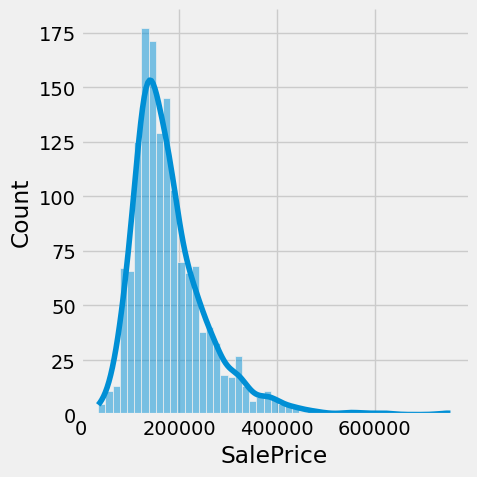

In [ ]:
sns.displot(x=train_data['SalePrice'], kde=True)
plt.show()

In [16]:
def standardize_scale(data, col):
    """
    Standardize and scale a numeric column in a DataFrame using Z-score normalization technique.

    This function takes a DataFrame and the name of a numeric column, calculates
    the mean and standard deviation of the column, and then standardizes the values
    in the column by subtracting the mean and dividing by the standard deviation.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.
    - col (str): The name of the numeric column to be standardized and scaled.

    Returns:
    - Series: A pandas Series containing the standardized and scaled values of the column.

    Example:
    If 'data' is a DataFrame and 'my_column' is a numeric column in the DataFrame,
    you can standardize and scale it using:
    >>> scaled_column = standardize_scale(data, 'my_column')
    """

    column_mean = data[col].mean()

    column_std = data[col].std()

    return ((data[col] - column_mean) / column_std)

In [17]:
def visualise_data(data, list_cols, plot_type, target=None, display_corr_score=False, standardize_values=False,**kwargs):
    """
    Generate and display visualizations of data using various plot types.

    Parameters:
        data (pd.DataFrame): The pandas DataFrame containing the data to be visualized.
        list_cols (list): List of column names to be visualized.
        plot_type (str): Type of plot to be generated. Supported values: "scatterplot", "histplot", "countplot".
        target (str, optional): Dependent variable for scatterplot. Required only when plot_type is "scatterplot".
        display_corr_score (bool, optional): Whether to display correlation scores in scatterplot. Default is False.
        **kwargs: Additional keyword arguments passed to plt.subplots for figure customization.

    Returns:
        None (Displays the generated plots using matplotlib and seaborn.)

    Raises:
        None

    Notes:
        - For scatterplots, if the plot_type is "scatterplot", the function standardizes the values
          of the selected columns before plotting.
        - When plot_type is "scatterplot", the target parameter must be provided to indicate the
          dependent variable for the scatterplot.
    Example:
        ```
        import pandas as pd

        # Create a sample DataFrame
        data = pd.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50], 'C': ['X', 'Y', 'X', 'Z', 'Z']})

        # Visualize selected columns as histograms
        visualise_data(data, ['A', 'B'], 'histplot')

        # Visualize a scatterplot between columns A and B with 'target' as the dependent variable
        visualise_data(data, ['A', 'B'], 'scatterplot', target='target_column')

        # Visualize countplot of categorical column C
        visualise_data(data, ['C'], 'countplot')
        ```
    """

    if plot_type not in  ["scatterplot", "histplot", "countplot"]:
        print(f"Invalid plot_type specified: Can only show [scatterplot, histplot, countplot]")
        return
    if target == None and plot_type == "scatterplot":
        print(f"Cannot draw a scatterplot. Dependent variable not specified.\nSpecify Dependent variable by passing target argument to function call.")
        return

    num_plots = len(list_cols)
    num_cols = 4
    num_rows = -(-num_plots // num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), **kwargs)
    for idx, column in enumerate(list_cols):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]
        if plot_type == "scatterplot" and standardize_values==False:
            sns.scatterplot(x=data[column], y=data[target], ax=ax)
            ax.set_ylabel(target, fontsize=14)
            ax.set_xlabel(column, fontsize=14)
            if display_corr_score == True:
                correlation = data[column].corr(data[target])
                ax.text(.8, .9, f'corr: {correlation:.2f}', transform=ax.transAxes, fontsize=12, ha='center')
        elif plot_type == "scatterplot" and standardize_values==True:
            sns.scatterplot(x=standardize_scale(data, column), y=standardize_scale(data, target), ax=ax)
            ax.set_ylabel(target, fontsize=14)
            ax.set_xlabel(column, fontsize=14)
            if display_corr_score == True:
                correlation = data[column].corr(data[target])
                ax.text(.8, .9, f'corr: {correlation:.2f}', transform=ax.transAxes, fontsize=12, ha='center')

        elif plot_type == "histplot":
            sns.histplot(x=data[column], ax=ax)
            ax.set_xlabel(column, fontsize=14)
            ax.set_ylabel(" ")
        elif plot_type == "countplot":
            sns.countplot(x=data[column], ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

            ax.set_ylabel(" ")
            ax.set_xlabel(column, fontsize=14)

    for idx in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[idx])

    # Set the figure title based on plot type
    if plot_type == "scatterplot":
        fig.suptitle(f"Scatterplot of Continuous Numerical features With {target}", fontsize=16)
    elif plot_type == "histplot":
        fig.suptitle("Histograms of Numerical Discrete features", fontsize=16)
    elif plot_type == "countplot":
        fig.suptitle("Countplot of Categorical features", fontsize=16)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
visualise_data?

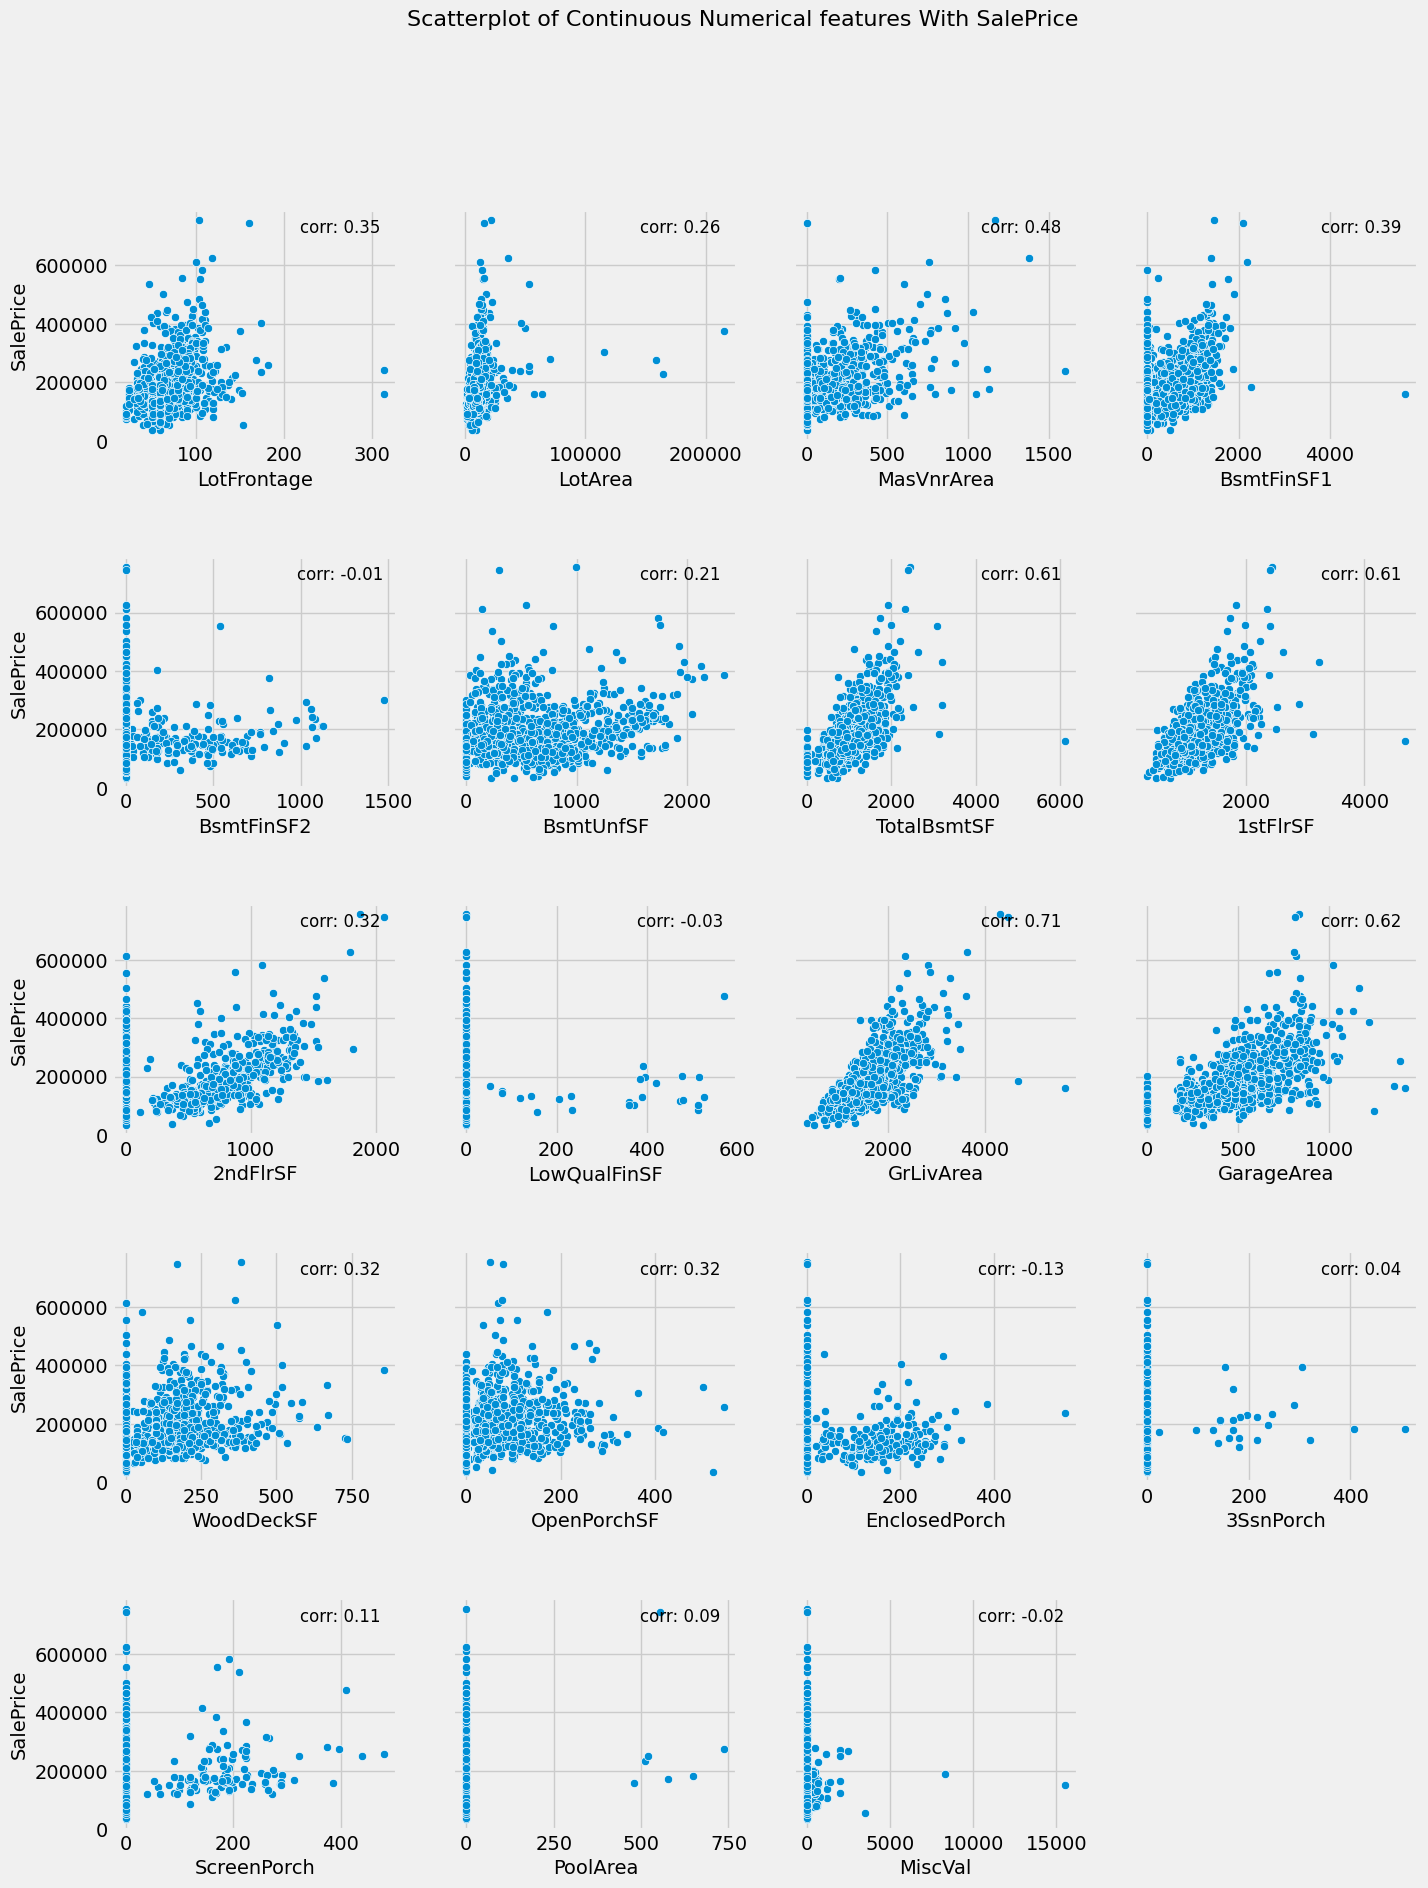

In [18]:
visualise_data(train_data, num_con, 'scatterplot', target='SalePrice', display_corr_score=True, sharey=True)

Looking at the above scatterplots we can clearly see some outliers in our features. Couple of features such as GarageArea , LotFrontage , MasVnrArea , BsmtFinSF1 , TotalBsmtSF , 1stFlrSF , GrLivArea show some irregular values in the dataset and as such these values should be removed
1. Looking at the correlation scores in the graphs it is clear that some variables are moderately to highly correlated with SalePrice while others do not show any correlation.
2. For training a linear regression model, the variables which show little to no correlation should be dropped from both datsets because they provide no information to the model and can negatively imapct the performance.

In [19]:
def remove_outliers(data, col, cut_off):
    # The first condition makes sure that rows containg null values are not dropped.
    return data[(data[col].isnull()) | (data[col] < cut_off)]

In [20]:
print(f"Train Data Shape before removing extraneous values: {train_data.shape}")

train_data = remove_outliers(train_data, 'LotFrontage', 170)
train_data = remove_outliers(train_data, 'LotArea', 100000)
train_data = remove_outliers(train_data, 'MasVnrArea', 1000)
train_data = remove_outliers(train_data, 'BsmtFinSF1', 2000)
train_data = remove_outliers(train_data, 'BsmtFinSF2', 1200)
train_data = remove_outliers(train_data, 'TotalBsmtSF', 3000)
train_data = remove_outliers(train_data, '1stFlrSF', 2600)
train_data = remove_outliers(train_data, 'GrLivArea', 4000)
train_data = remove_outliers(train_data, 'GarageArea', 1200)
train_data = remove_outliers(train_data, 'WoodDeckSF', 500)
train_data = remove_outliers(train_data, 'OpenPorchSF', 400)
train_data = remove_outliers(train_data, 'EnclosedPorch', 380)

print(f"Train Data Shape  after removing extraneous values: {train_data.shape}")

Train Data Shape before removing extraneous values: (1460, 80)
Train Data Shape  after removing extraneous values: (1410, 80)


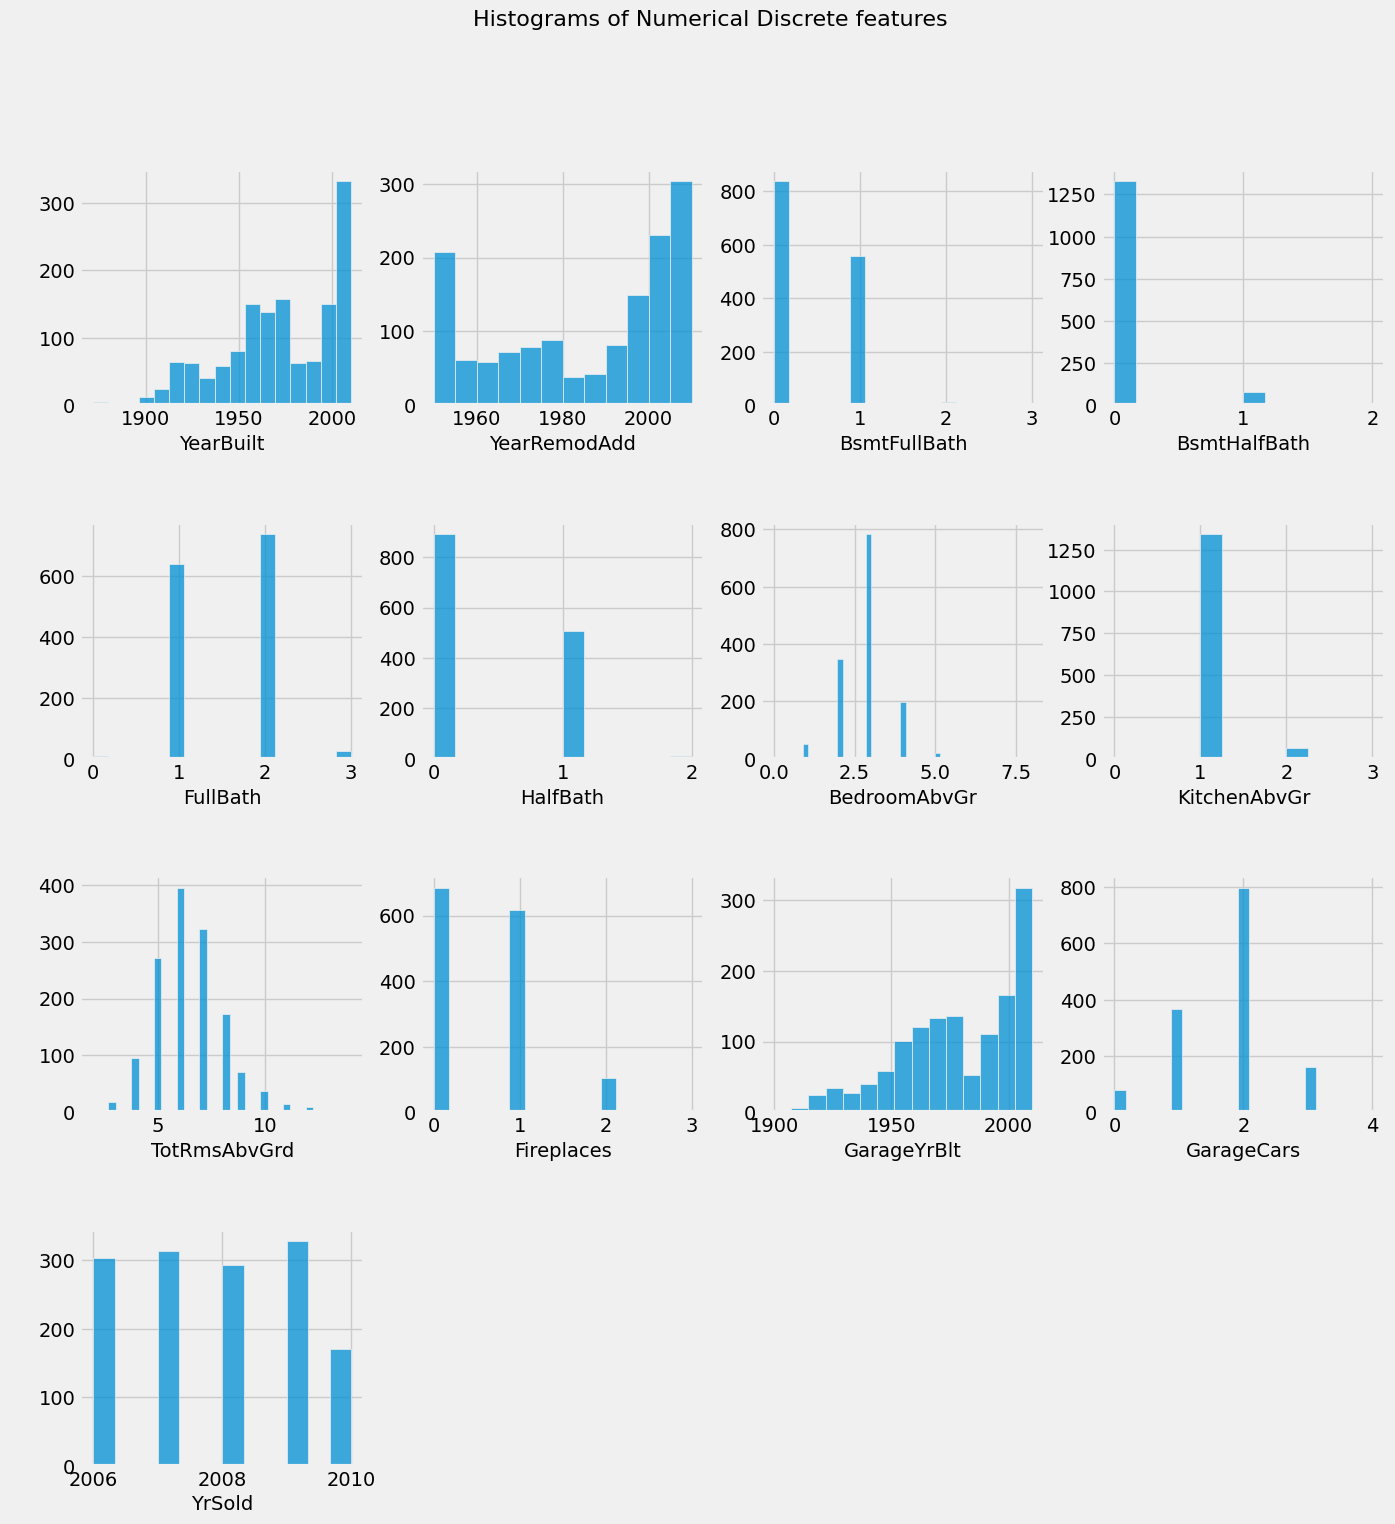

In [21]:
visualise_data(train_data, num_dis, "histplot")

Couple of things point out by looking at these histplots.
1. All  numerical discrete variables take on a range of values from 0-12 except for MoSold, YrSold, GarageYrBlt, YearBuilt, and YearRemodAdd.
2. Large range and values of these features could potenially impact the model performance.
3. New features can be created from them.

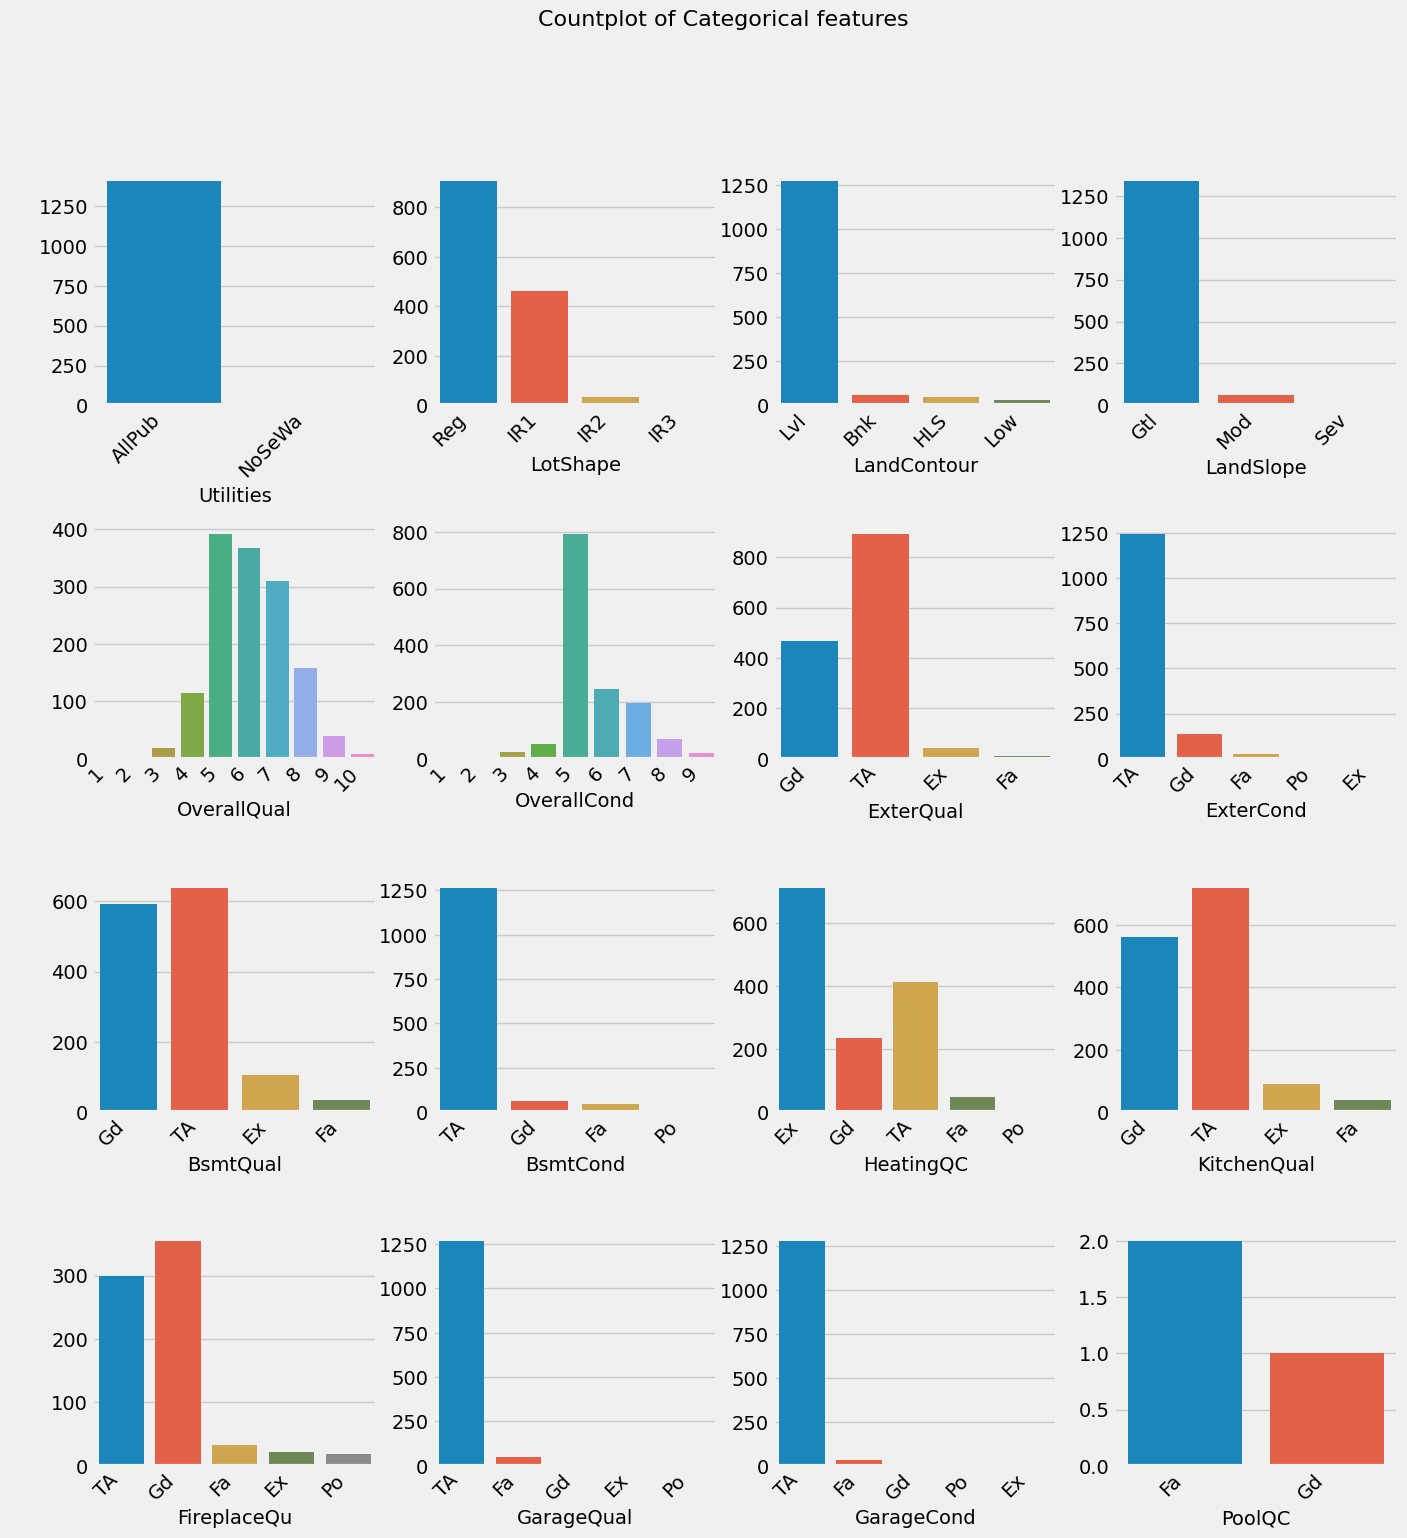

In [ ]:
visualise_data(train_data, cat_ord, "countplot")

Following observations can be made by looking at the graphs of these features
1. For these features we need to keep in mind that the values in them have ordered relationship between them.
2. There are many features with only a single dominant value. For example "Utilities" feature takes on a single value of AllPub for almost all cases (more than 1400).
3. Features such as FireplaceQu, GarageQual, and GarageCond can all be encoded as ordinal values.
4. To efficiently convert these values into numbers, and also to preserve the natural ranking between them using OrdinalEncoder class we need to define a mapping for the values.

In [ ]:
# # Check to see the different unique values in ordinal features. This will help in defining mapping

# display(case_description.loc['HeatingQC', :, :])
# print(case_description.loc['HeatingQC', :, :].index)

In [22]:
# Define mapping for categorical ordinal features in train_data

cat_ord_map1 = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}
cat_ord_map2 = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
cat_ord_map3 = {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1}
cat_ord_map4 = {'Gtl': 3, 'Mod': 2, 'Sev': 1}
cat_ord_map5 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
cat_ord_map6 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
cat_ord_map7 = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10}
cat_ord_map8 = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
cat_ord_map9 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2}

Now lets visualise the categorical nominal variables in the dataset

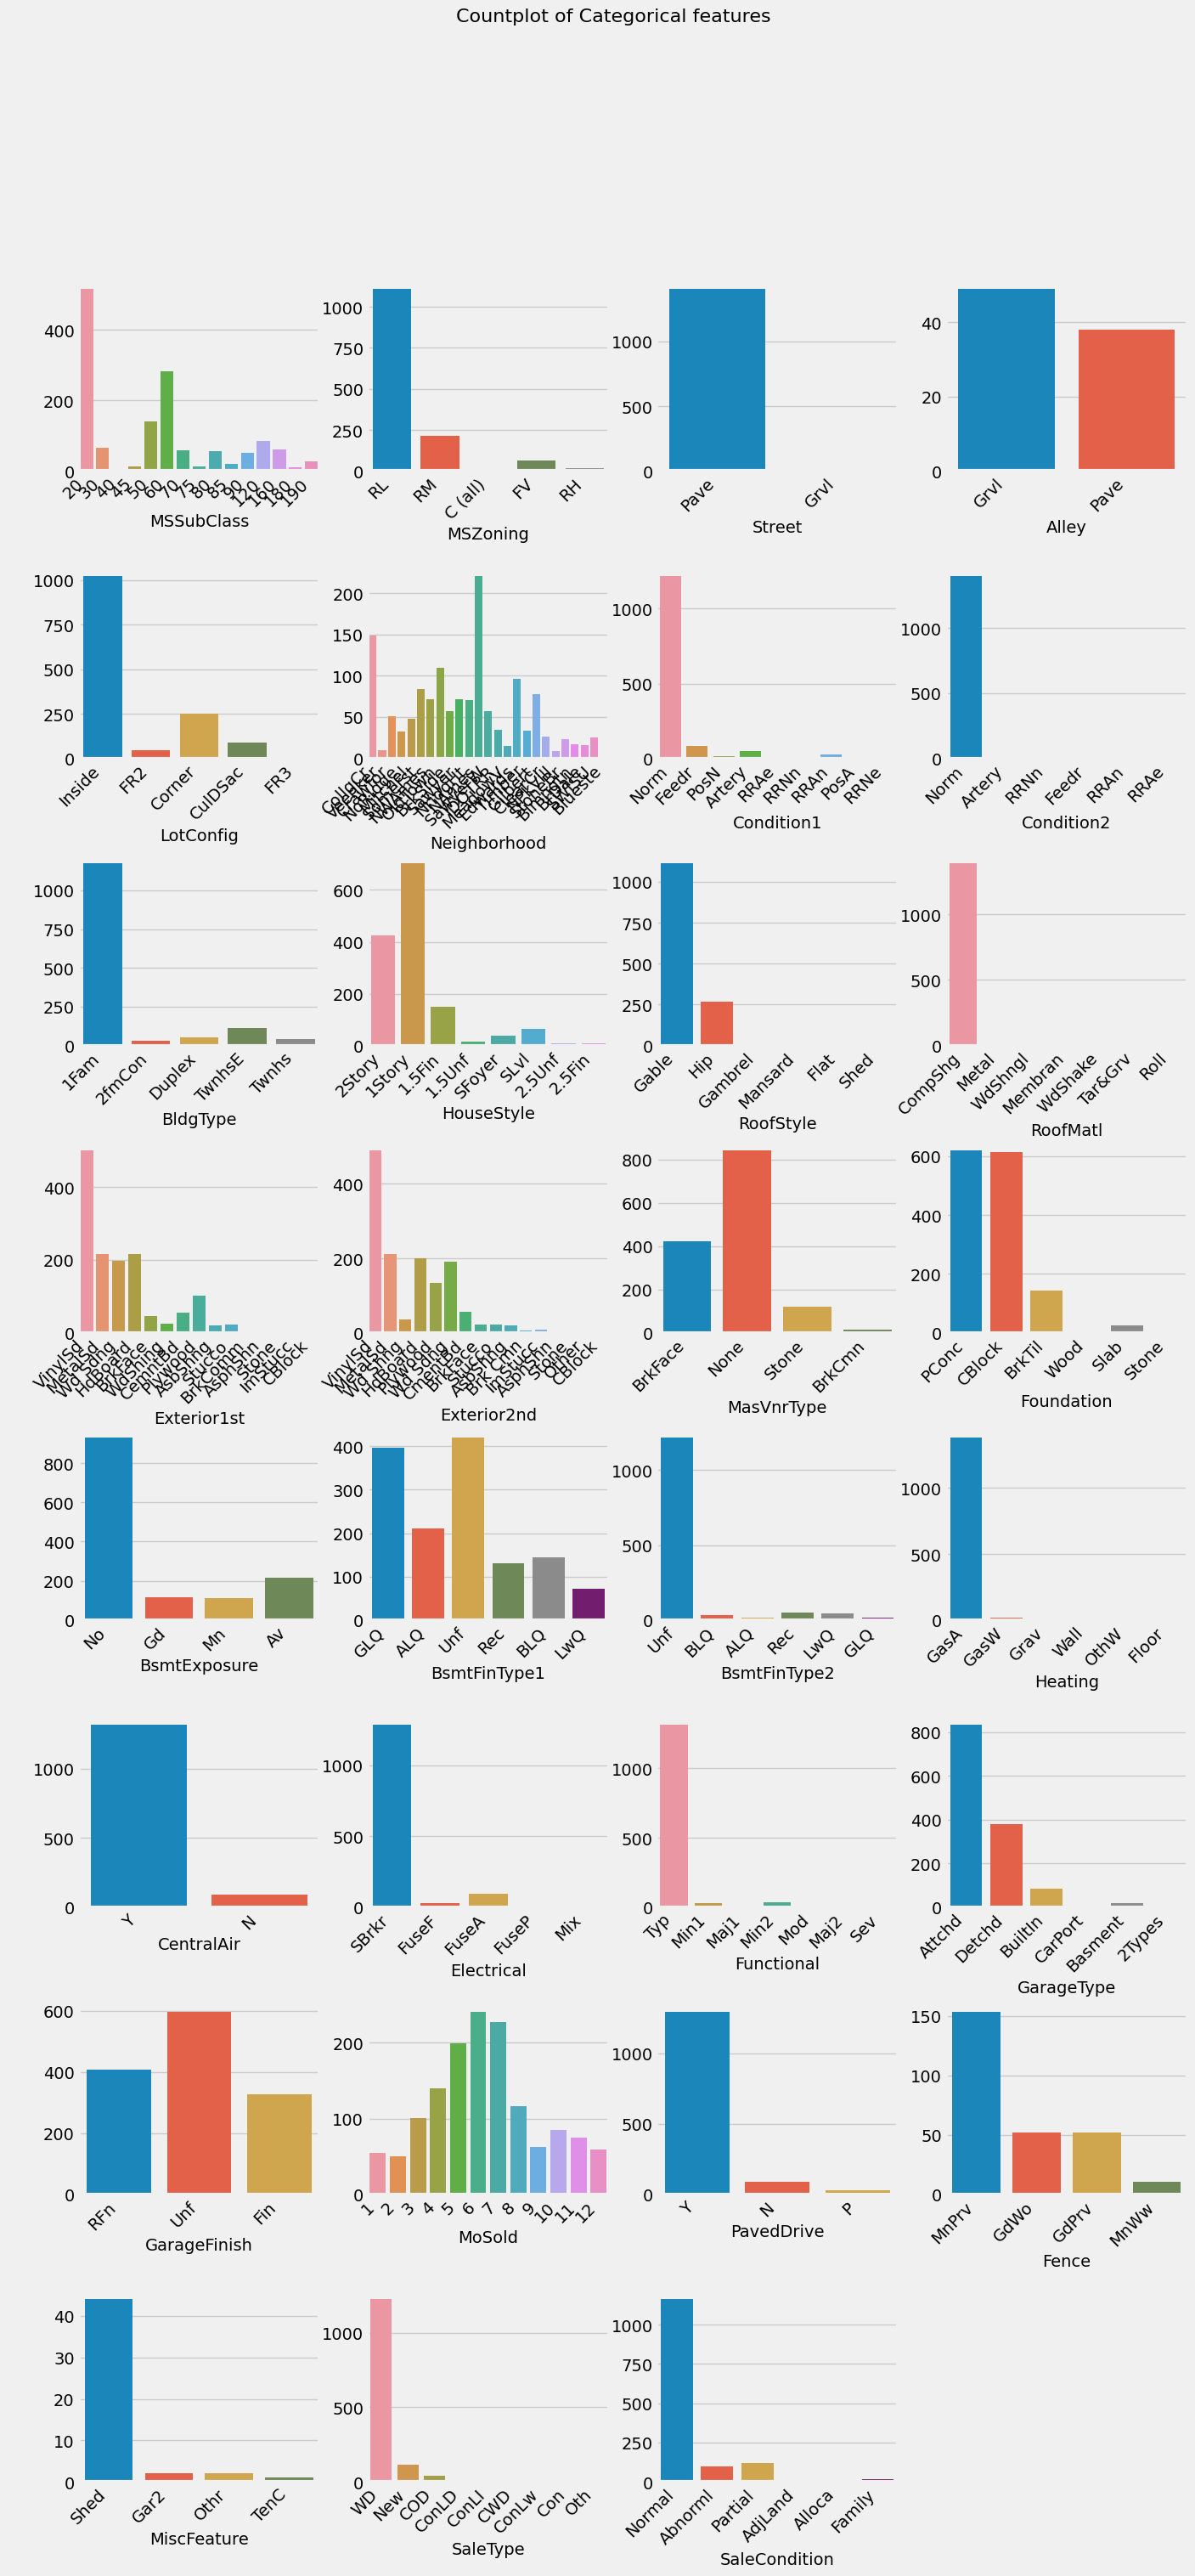

In [ ]:
visualise_data(train_data, cat_nom, "countplot")

The categrical nominal features also follow the same pattern as ordinal features
1. There are many features with a single dominant value. For example variable 'Street' takes only a single value of 'Pave' for almost all cases (more than 1100)
2. Other features such as MSSubclass, MsZoning, and Neighbourhood have some cases whose frequency is more than rest of the cases.
3. Variable 'Alley' has a lot of missing values becasue as seen total count of values for all cases is less than 100.
4. These variables can be handled by creating dummy values.

### 2. Data Preparation

The next step in KDD is data preparation. Data preparation involves best exposing the unknown underlying structure of the problem to learning algorithms.
As each dataset is unique and highly specific to the project it is difficult to say which methods will be used to prepare the data beforehand. But there are common taks that can be performed during preparation. Those tasks are:
- Data Cleaning
- Feature Selection
- Data Transform
- Feature Engineering

#### Data Cleaning


The steps we take to identify errors in the data and fix them are listed below:<br>

1. Report number of unique values in a column and also print them out as a proportion of the total values in the column (only numeric features)
2. Identifying and Deleting columns with a single value
3. Identifying columns which have very few unique values
4. Reporting the variance in values of different columns (implement our own logic or use VarianceThreshold() class from sklearn)
5. Identifying and reporting the total number of duplicate rows
6. Display duplicated rows and delete them.
7. Report total count of missing values and their proportion in each column
8. Identify potential values (if any) which could be marked as missing
9. Impute missing values using a summary statistic
10. Encode any numerical variables with discrete values into ordinal values (from int (discrete)-> int (ordinal)


**We will now change dtypes of columns which might have been misinterpreted by pandas.**

Looking at the dataset it is clear that cols OverallQual, OverallCond are categorical ordinal while MSSubClass, MoSold are categorical nominal.

*Data type of these features is changed for both training and test datasets*

In [23]:
train_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']] = train_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].astype('str')
test_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']] = test_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].astype('str')

print(f"In train Data:\n\n{train_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].dtypes}")

print(f"\n\nIn test Data:\n\n{test_data[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].dtypes}")

In train Data:

MSSubClass     object
OverallQual    object
OverallCond    object
MoSold         object
dtype: object


In test Data:

MSSubClass     object
OverallQual    object
OverallCond    object
MoSold         object
dtype: object


In [24]:
print(f"{'Column':<15} {'Unique Values':<16} {'Variance':<15} {'Proportion':<16}")
print('_' * (shutil.get_terminal_size().columns), '\n')

for column in numeric_columns:
    unique_values = train_data[column].nunique()
    total_values = train_data.shape[0]

    proportion = (unique_values / total_values) * 100
    var = np.var(train_data[column], ddof=1) # ddof is the degress of freedom, when set to 1 will divide by n-1 values

    print(f"{column:<15} {unique_values:<16} {var:<15.2f} {proportion:<12.2f}")

Column          Unique Values    Variance        Proportion      
________________________________________________________________________________ 

LotFrontage     105              444.18          7.45        
LotArea         1031             24964307.96     73.12       
MasVnrArea      307              24649.49        21.77       
BsmtFinSF1      610              174693.00       43.26       
BsmtFinSF2      137              23772.05        9.72        
BsmtUnfSF       764              192071.37       54.18       
TotalBsmtSF     696              154480.75       49.36       
1stFlrSF        723              124530.33       51.28       
2ndFlrSF        400              179210.64       28.37       
LowQualFinSF    23               2341.08         1.63        
GrLivArea       824              226193.00       58.44       
GarageArea      423              42763.41        30.00       
WoodDeckSF      253              12538.45        17.94       
OpenPorchSF     191              3700.83     

Looking at the numeric_columns from our dataset it is clear that cols OverallQual, OverallCond are categorical ordinal while MSSubClass, MoSold are categorical nominal

In [25]:
single_value_columns = [col for col in train_data.columns if train_data[col].nunique() == 1]
train_data.drop(single_value_columns, axis=1, inplace=True)

print(f"Single value columns: {single_value_columns}")
print("Dropped columns:", single_value_columns)

Single value columns: []
Dropped columns: []


In [26]:
#counts the number of True(duplicate) values
print('Total number of duplicated rows in train_data:', train_data.duplicated().sum())

Total number of duplicated rows in train_data: 0


In [27]:
print('Total number of duplicated rows in test_data:',test_data.duplicated().sum())

Total number of duplicated rows in test_data: 0


As seen in the data visualisations before, there are many features which contained a dominant single value. These features have variance very close to zero and as such they provide no information to the learning algorithm and they can be misleading and impact model performance negatively.


Let's take a look at the columns which have a dominant single value with more than 1300 value_counts.

In [28]:
print(f"{'Column':<15} {'Dominant Value':<16} {'Value Count(> 1300)':<15}")
print('_' * (shutil.get_terminal_size().columns), '\n')

for column in train_data.columns:
    value_count = train_data[column].value_counts()
    for case, count in value_count.to_dict().items():
        if count > 1300:
            print(f"{column:<15} {case:<16} {count:<15}")
            break # as there no need to check for further cases

Column          Dominant Value   Value Count(> 1300)
________________________________________________________________________________ 

Street          Pave             1406           
Utilities       AllPub           1409           
LandSlope       Gtl              1339           
Condition2      Norm             1399           
RoofMatl        CompShg          1391           
Heating         GasA             1381           
CentralAir      Y                1318           
LowQualFinSF    0                1385           
BsmtHalfBath    0                1331           
KitchenAbvGr    1                1342           
Functional      Typ              1313           
3SsnPorch       0                1386           
PoolArea        0                1407           
MiscVal         0                1363           


Looking at the output from above we can see that many features in the dataset are dominated by a single value. We can drop these features from our dataset but only looking at features with more than 1300 values is subjective. A better approach is to see how does the total number of columns to drop increases as we decrease the threshold for single dominant value from 1300 to 1200 and so on.

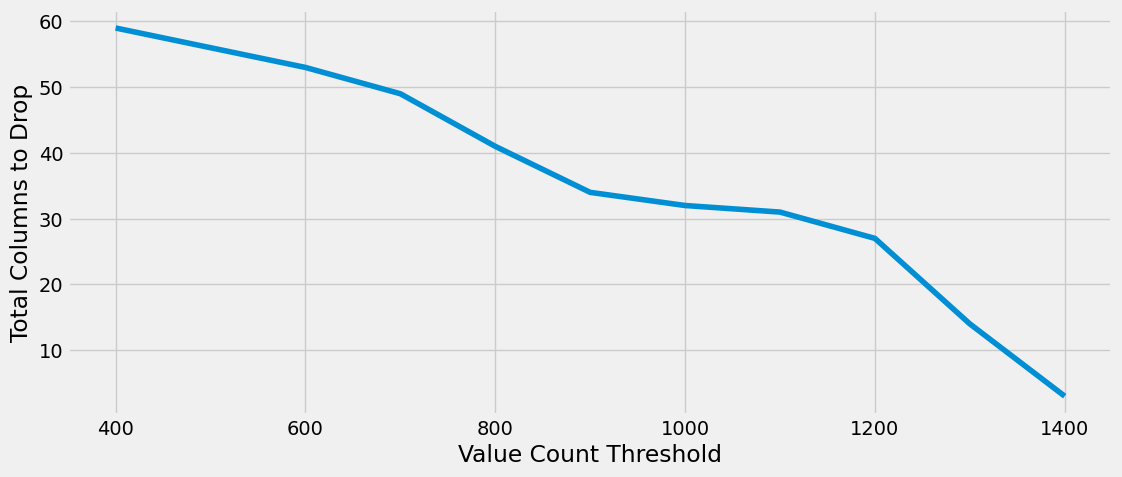

In [29]:
num_cols_to_drop = list() # list of total number of columns to drop at a particular threshold
threshold = list(range(400, 1500, 100))

for t in threshold:
    total_cols = 0
    for column in train_data.columns:
        value_count = train_data[column].value_counts()
        for case, count in value_count.to_dict().items():
            if count > t:
                total_cols += 1
                break # as there no need to check for further cases
    num_cols_to_drop.append(total_cols)

plt.figure(figsize=(12,5))
plt.plot(threshold, num_cols_to_drop)

plt.xlabel("Value Count Threshold")
plt.ylabel("Total Columns to Drop")
plt.show()

The lineplot shows that there are almost 50 features in training dataset which have a single value with more than 700 cases. The line tends to flatten as the threshold approaches to 900 to 1100 values. This could be a good point to set the threshold and any features which contain a value_count above this threshold will be dropped from both datasets.

In [30]:
cols_to_drop = list()

for column in train_data.columns:
    value_count = train_data[column].value_counts()
    for case, count in value_count.to_dict().items():
        if count > 900: # Set threshold to 900
            cols_to_drop.append(column)
            break

print("Columns to be dropped because they contain a single value for most of the observations:\n")
print(cols_to_drop)
print(f"\nTotal columns to be dropped: {len(cols_to_drop)}")

Columns to be dropped because they contain a single value for most of the observations:

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition']

Total columns to be dropped: 34


In [31]:
# drop columns in train dataset

train_data.drop(cols_to_drop, axis=1, inplace=True)
print(f"Train data shape after dropping columns with single dominant value: {train_data.shape}")

Train data shape after dropping columns with single dominant value: (1410, 46)


In [32]:
# drop columns in test dataset

test_data.drop(cols_to_drop, axis=1, inplace=True)
print(f"Test data shape after dropping columns with single dominant value: {test_data.shape}")

Test data shape after dropping columns with single dominant value: (1459, 45)


In [33]:
# Remove dropped columns from the num_con, num_ord, cat_nom, cat_ord, numeric_columns, and
# categorical_columns as they are not part of further analysis

for col in cols_to_drop:
    if col in cat_nom:
        cat_nom.remove(col)
        categorical_columns.remove(col)
    elif col in cat_ord:
        cat_ord.remove(col)
        categorical_columns.remove(col)
    elif col in num_dis:
        num_dis.remove(col)
        numeric_columns.remove(col)
    elif col in num_con:
        num_con.remove(col)
        numeric_columns.remove(col)

##### Handling Missing Values

We saw in the visualisations before that there are many featurees which contained null values. Machine learning algorithms suffer when there are null values in the dataset and as such we impute them using a summary statistic or drop those rows completely.
- In our case we will drop features which contain a significant number of null values
- Impute null values for the rest of features using a summary statistic

In [34]:
# total number of null values in train_data
total = train_data.isnull().sum().sort_values(ascending=False)

# percentage of total null_values in train_data
percent = ((train_data.isnull().sum() / train_data.shape[0]) * 100).sort_values(ascending=False)

# create DataFrame of missing values
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

# drop columns which had 0 missing values from the DataFrame
no_missing_cols = missing_data[missing_data['Total Missing'] == 0].index
missing_data.drop(no_missing_cols, inplace=True)
missing_data.index.name = 'Training Feature'

display(missing_data.style.set_caption("<b>Missing values in train_data</b>"))

,Total Missing,Percent
Training Feature,,
PoolQC,1407,99.787234
MiscFeature,1361,96.524823
Alley,1323,93.829787
Fence,1142,80.992908
FireplaceQu,685,48.581560
LotFrontage,246,17.446809
GarageYrBlt,80,5.673759
GarageFinish,80,5.673759
GarageType,80,5.673759


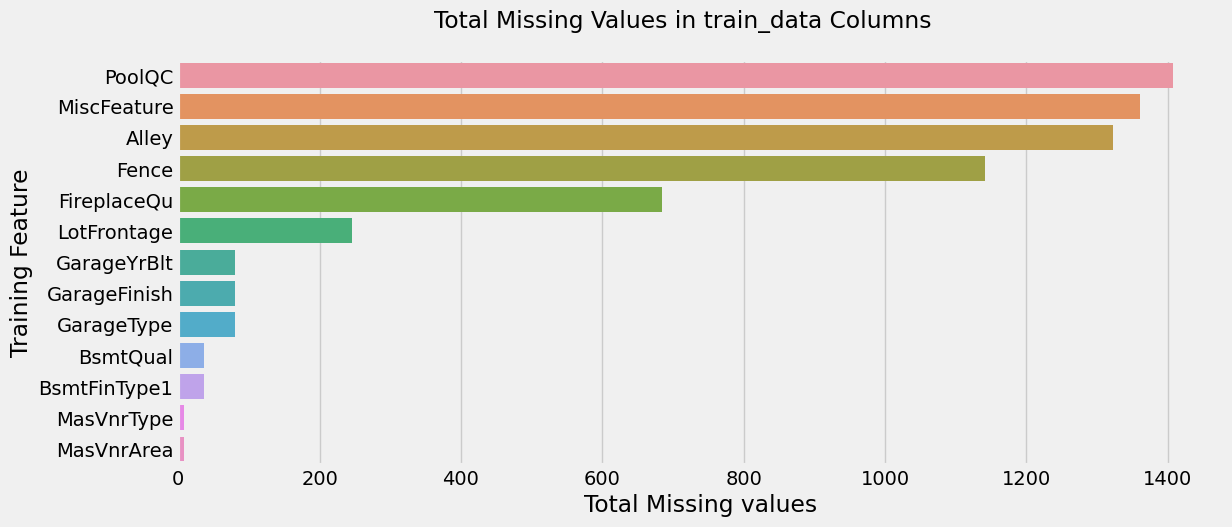

In [35]:
plt.figure(figsize=(12,5))
sns.barplot(x=missing_data['Total Missing'], y=missing_data.index)

plt.xlabel("Total Missing values")
plt.ylabel("Training Feature")
plt.suptitle("Total Missing Values in train_data Columns")
plt.show()

As seen in the output there are 5 features in the dataset which contain a significant number of null values. These features should be dropped from both training and test_datasets

In [37]:
# drop all columns from train_data and test_data which had more than 45% missing values
cols_to_drop = list(missing_data[missing_data['Percent'] > 45].index)

print(f"Columns to be dropped due to significant number of missing values:\n{cols_to_drop}")

print(f"\nTotal columns to be dropped: {len(cols_to_drop)}")

Columns to be dropped due to significant number of missing values:
['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

Total columns to be dropped: 5


In [38]:
# drop columns in train data
train_data = train_data.drop(cols_to_drop, axis=1)

print(f"Train data shape after dropping columns with significant missing values: {train_data.shape}")

Train data shape after dropping columns with significant missing values: (1410, 41)


In [39]:
# drop columns from test_data
test_data = test_data.drop(cols_to_drop, axis=1)

print(f"Test data shape after dropping columns with significant missing values: {test_data.shape}")

Test data shape after dropping columns with significant missing values: (1459, 40)


In [40]:
# Remove dropped columns from the num_con, num_ord, cat_nom, cat_ord, numeric_columns, and
# categorical_columns as they are not part of further analysis

for col in cols_to_drop:
    if col in cat_nom:
        cat_nom.remove(col)
        categorical_columns.remove(col)
    elif col in cat_ord:
        cat_ord.remove(col)
        categorical_columns.remove(col)
    elif col in num_dis:
        num_dis.remove(col)
        numeric_columns.remove(col)
    elif col in num_con:
        num_con.remove(col)
        numeric_columns.remove(col)

# drop the cols from missing_data as well
missing_data.drop(cols_to_drop, inplace=True)

In [41]:
display(missing_data.style.set_caption("<b>Missing values in train_data</b>"))

,Total Missing,Percent
Training Feature,,
LotFrontage,246,17.446809
GarageYrBlt,80,5.673759
GarageFinish,80,5.673759
GarageType,80,5.673759
BsmtQual,37,2.624113
BsmtFinType1,37,2.624113
MasVnrType,8,0.567376
MasVnrArea,8,0.567376


In [42]:
# Fill missing values

missing_data_cols = list(missing_data.index)

# fill numeric columns with mean and categorical_columns with mode
for col in missing_data_cols:
  if col in numeric_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mean())
  elif col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

In [43]:
# check to see if all missing values have been filled

print(f"Total null values in train_data after imputing them: ", end="")
print(train_data.isnull().any(axis=1).sum())

Total null values in train_data after imputing them: 0


No we will handle missing values in test_data

In [44]:
# total number of null values in test_data
total = test_data.isnull().sum().sort_values(ascending=False)

# percentage of total null_values in test_data
percent = ((test_data.isnull().sum() / test_data.shape[0]) * 100).sort_values(ascending=False)

# create DataFrame of missing values
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

# drop columns which had 0 missing values from the DataFrame
no_missing_cols = missing_data[missing_data['Total Missing'] == 0].index
missing_data.drop(no_missing_cols, inplace=True)
missing_data.index.name = 'Feature'

display(missing_data.style.set_caption("<b>Missing values in test_data</b>"))

,Total Missing,Percent
Feature,,
LotFrontage,227,15.558602
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageType,76,5.209047
BsmtQual,44,3.015764
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
BsmtFullBath,2,0.137080


test_data has more features which are missing values than there were in train_data. We will use the same strategy for imputing values in test_data as we used for train_data.

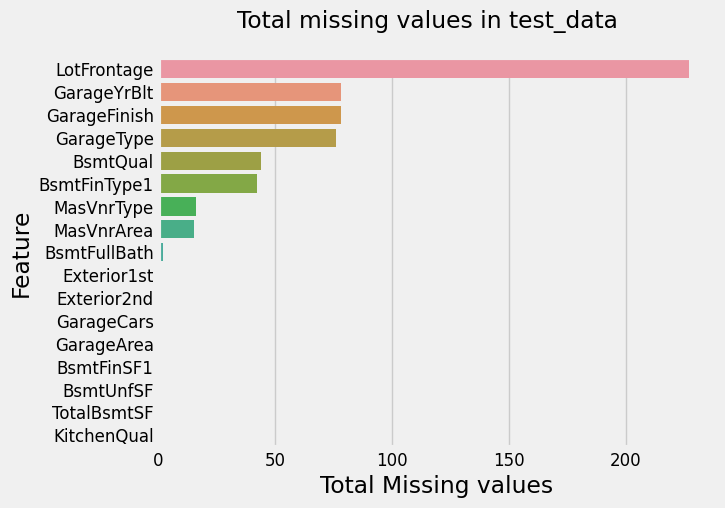

In [45]:
# barplot to visulaise the missing values in test_data
sns.barplot(x=missing_data['Total Missing'], y=missing_data.index)

plt.xlabel("Total Missing values")
plt.ylabel("Feature")
plt.suptitle("Total missing values in test_data")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [46]:
# fill missing values in test_data

missing_data_cols = list(missing_data.index)

# fill numeric_columns with mean and categorical_columns with mode
for col in missing_data_cols:
  if col in numeric_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mean())
  elif col in categorical_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

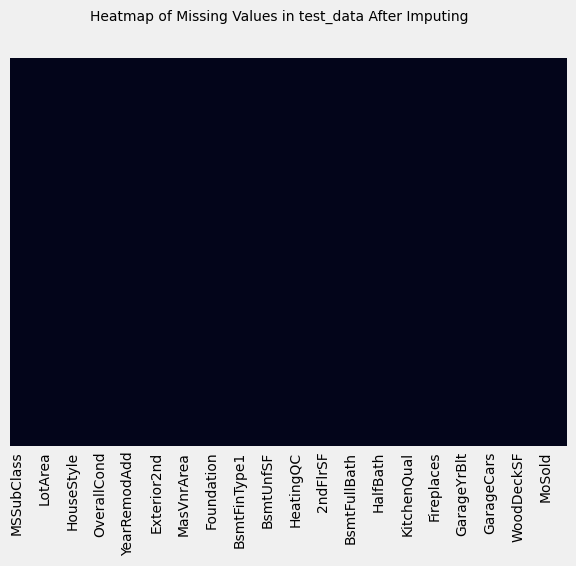

In [47]:
# heatmap to confirm all missing values have been filled in test_data
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False)

plt.xticks(fontsize=10)
plt.ylabel("")
plt.suptitle("Heatmap of Missing Values in test_data After Imputing", fontsize=10)
plt.show()

In [48]:
# check to see if all missing values have been filled

print(f"Total null values in test_data after imputing them: ", end="")
print(test_data.isnull().any(axis=1).sum())

Total null values in test_data after imputing them: 0


In [49]:
print(cat_nom)
print(cat_ord)
print(num_dis)
print(num_con)

['MSSubClass', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'GarageType', 'GarageFinish', 'MoSold']
['OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual']
['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'YrSold']
['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


Removing the skew in variables and log transform the target variable

In [50]:
#log transform the target:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

In [52]:
from scipy.stats import skew
#compute skewness in numerical column
skewed_features = train_data[numeric_columns].apply(lambda x: skew(x))

In [53]:
skewed_features = skewed_features[skewed_features > 0.5]
skewed_features = skewed_features.index
skewed_features

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'BsmtFullBath',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces'],
      dtype='object')

In [54]:
# Take log of skewed features

train_data[skewed_features] = np.log1p(train_data[skewed_features])
test_data[skewed_features] = np.log1p(test_data[skewed_features])

##### Encoding Variables


Most learning algorithms work best with numbers. That's why it is necessary encode all categorical features in the dataset. Couple of points to note here:
- Features as MSSubClass, Neighborhood can have different values in train_data and test_data
- If we were to create dummy values for train_data and test_data separately here then we could end up with a situation where one of the dataset has more features than the other. This is not what we want.
- As such both datasets should be concatenated, and then dummy variables will be created.
- After that we will split the datasets back into train_data and test_data.
- Categorical nominal variables are encoded using get_dummies function from pandas.

First, categorical nominal variables are enoded

In [55]:
combined_data = pd.concat([train_data, test_data], axis=0)
print(f"Combined data shape: {combined_data.shape}")

Combined data shape: (2869, 41)


In [56]:
## create dummy variables only for categorical nominal columns
dummy_data = pd.get_dummies(combined_data[cat_nom], drop_first=True)
print(dummy_data.shape)


(2869, 106)


In [57]:
# Combine dummy_data and combined_data together
combined_data = pd.concat([combined_data, dummy_data], axis=1)
print(combined_data.shape)

(2869, 147)


In [58]:
# Before splitting combined_data we need to drop those columns whose values have now been encoded
combined_data.drop(cat_nom, axis=1, inplace=True)
print(combined_data.shape)

(2869, 136)


In [59]:
# Split combined_data back into train_data and test_data
# We will take advantage of the index ('Id' column) from both datasets and use the loc operator to index into combined_data.

train_data = combined_data.loc[train_data.index, :]
test_data = combined_data.loc[test_data.index, :]

# drop SalePrice column from test_data
test_data.drop('SalePrice', axis=1, inplace=True)

# Summarize the shape of datasets
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1410, 136)
Test data shape: (1459, 135)


In [60]:
# free up space taken by combined_data, and dummy_data variables
del combined_data, dummy_data

Now to encode categorical ordinal variables. Because mapping has already been defined for these features, we can use that mapping to encode values in ordinal features.

In [61]:
custom_mappings = [cat_ord_map1, cat_ord_map2, cat_ord_map3, cat_ord_map4, cat_ord_map5, cat_ord_map6,
                   cat_ord_map7, cat_ord_map8, cat_ord_map9]
for col in cat_ord:
    for mapping in custom_mappings:
        if set(train_data[col].unique()) == set(mapping):
            train_data[col] = train_data[col].map(mapping)
            test_data[col] = test_data[col].map(mapping)
            break

In [62]:
pd.set_option('display.max.columns', None)
display(train_data[num_con + ['SalePrice']].describe().loc[['min', 'max', 'std', 'mean']])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
min,21.000000,7.170888,0.000000,0.000000,0.000000,0.000000,5.814131,0.000000,5.814131,0.000000,0.000000,0.000000,10.471978
max,168.000000,11.167077,6.883463,7.552237,7.756623,2524.000000,7.833996,7.506042,8.191186,1166.000000,6.206576,5.899897,13.275829
std,19.147590,0.481856,2.595647,2.987525,1.864296,393.040391,0.306530,3.282179,0.320376,206.793155,2.571871,2.144843,0.383041
mean,68.927835,9.086454,2.096194,4.184803,5.641720,1034.375887,6.994501,2.837368,7.253395,465.002128,2.405373,2.263852,12.007609


In [63]:
list(set(train_data.dtypes))
list(set(test_data.dtypes))

[dtype('int64'), dtype('uint8'), dtype('float64')]

***Check for invalid data entires***


*   Before moving we need to make sure that there no entries in the datasets where YrSold is less than YearBuilt.
*   Similarly we need to make sure there are no cases where GarageYrBlt is less than YearBuilt or greate than YrSold

*  Also for YearRemodAdd feature let's check whether any of the entries in it are less than YearBuilt or greater than YrSold

In [64]:
print("Total cases in train_data where YrSold is less than YearBuilt: ", end="")
print((train_data['YrSold'] < train_data['YearBuilt']).sum())

print("\nTotal cases in test_data where YrSold is less than YearBuilt: ", end="")
print((test_data['YrSold'] < test_data['YearBuilt']).sum())

Total cases in train_data where YrSold is less than YearBuilt: 0

Total cases in test_data where YrSold is less than YearBuilt: 1


In [65]:
invalid_rows = test_data.loc[test_data['YrSold'] < test_data['YearBuilt'], ['YrSold', 'YearBuilt']].index

test_data.loc[invalid_rows, 'YrSold'] = test_data.loc[invalid_rows, 'YearBuilt']

test_data.loc[test_data['YrSold'] < test_data['YearBuilt'], ['YrSold', 'YearBuilt']]

,YrSold,YearBuilt
Id,,


In [66]:
print("Total cases in train_data where GarageYrBlt is less than YearBuilt: ", end="")
print((train_data['GarageYrBlt'] < train_data['YearBuilt']).sum())

print("\nTotal cases in test_data where GarageYrBlt is less than YearBuilt : ", end="")
print((test_data['GarageYrBlt'] < test_data['YearBuilt']).sum())

Total cases in train_data where GarageYrBlt is less than YearBuilt: 17

Total cases in test_data where GarageYrBlt is less than YearBuilt : 20


In [69]:
invalid_rows = train_data.loc[train_data['GarageYrBlt'] < train_data['YearBuilt'], ['GarageYrBlt', 'YearBuilt']].index

train_data.loc[invalid_rows, 'GarageYrBlt'] = train_data.loc[invalid_rows, 'YearBuilt']

train_data.loc[train_data['GarageYrBlt'] < train_data['YearBuilt'], ['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
Id,,


In [68]:
invalid_rows = test_data.loc[test_data['GarageYrBlt'] < test_data['YearBuilt'], ['GarageYrBlt', 'YearBuilt']].index

test_data.loc[invalid_rows, 'GarageYrBlt'] = test_data.loc[invalid_rows, 'YearBuilt']

test_data.loc[test_data['GarageYrBlt'] < test_data['YearBuilt'], ['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
Id,,


In [70]:
print("Total cases in train_data where GarageYrBlt is greater than YrSold: ", end="")
print((train_data['GarageYrBlt'] > train_data['YrSold']).sum())

print("\nTotal cases in test_data where GarageYrBlt is greater than YrSold : ", end="")
print((test_data['GarageYrBlt'] > test_data['YrSold']).sum())

Total cases in train_data where GarageYrBlt is greater than YrSold: 0

Total cases in test_data where GarageYrBlt is greater than YrSold : 1


In [71]:
invalid_rows = test_data.loc[test_data['GarageYrBlt'] > test_data['YrSold'], ['GarageYrBlt', 'YrSold']].index

test_data.loc[invalid_rows, 'GarageYrBlt'] = test_data.loc[invalid_rows, 'YearBuilt']

test_data.loc[test_data['GarageYrBlt'] > test_data['YrSold'], ['GarageYrBlt', 'YrSold']]

,GarageYrBlt,YrSold
Id,,


In [72]:
print("Total cases in train_data where YearRemodAdd is less than YearBuilt: ", end="")
print((train_data['YearRemodAdd'] < train_data['YearBuilt']).sum())

print("\nTotal cases in test_data where YearRemodAdd is less than YearBuilt : ", end="")
print((test_data['YearRemodAdd'] < test_data['YearBuilt']).sum())

Total cases in train_data where YearRemodAdd is less than YearBuilt: 0

Total cases in test_data where YearRemodAdd is less than YearBuilt : 1


In [73]:
invalid_rows = test_data.loc[test_data['YearRemodAdd'] < test_data['YearBuilt'], ['YearRemodAdd', 'YearBuilt']].index

test_data.loc[invalid_rows, 'YearRemodAdd'] = test_data.loc[invalid_rows, 'YearBuilt']

test_data.loc[test_data['YearRemodAdd'] < test_data['YearBuilt'], ['YearRemodAdd', 'YearBuilt']]

,YearRemodAdd,YearBuilt
Id,,


In [75]:
print("Total cases in train_data where YearRemodAdd is greater than YrSold: ", end="")
print((train_data['YearRemodAdd'] > train_data['YrSold']).sum())

print("\nTotal cases in test_data where YearRemodAdd is greater than YrSold : ", end="")
print((test_data['YearRemodAdd'] > test_data['YrSold']).sum())

Total cases in train_data where YearRemodAdd is greater than YrSold: 0

Total cases in test_data where YearRemodAdd is greater than YrSold : 2


In [76]:
invalid_rows = test_data.loc[test_data['YearRemodAdd'] > test_data['YrSold'], ['YearRemodAdd', 'YrSold']].index

test_data.loc[invalid_rows, 'YearRemodAdd'] = test_data.loc[invalid_rows, 'YrSold']

test_data.loc[test_data['YearRemodAdd'] > test_data['YrSold'], ['YearRemodAdd', 'YrSold']]

,YearRemodAdd,YrSold
Id,,


Now as seen in the output we have removed any invalid data entries and set them equal to the built date or sold date accordingly

**Splitting Data**

Once we have cleaned the datasets, we can now split them into train and test sets.

In [77]:
from sklearn.model_selection import train_test_split

X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [78]:
print(f"Train {X_train.shape}, {y_train.shape}")
print(f"Test  {X_test.shape},  {y_test.shape}")

Train (1128, 135), (1128,)
Test  (282, 135),  (282,)


# **Data Transform**

Many learning algorithms perform better when input values are scaled to a standard range. Large input values can result in algorithm learning very large coefficients which can negatively impact performance, and model gives preference to values with large scale and other features are rendered useless.

The most popular technique for transforming input values are standardization, and normalisation. Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

Another technique is standardizing the values using RobustScaler which is particularly useful when there are outlier values in input data.

**Avoiding Data Leakage**

Data Leakage refers to the problem where information about the test data is made available to model before hand. This can have different reasons. One reason is that model is trained on test data so naturally model knows about test data.

When we scale values in training data, most of the times entire data is used to fit to the scaler object and then the data is split into train and test sets. But this approach can cause data leakage. For example, consider the case where we want to normalize data, that is scale input variables to the range 0-1. When we normalize the input variables, this requires that we first calculate the minimum and maximum values for each variable before using these values to scale the variables. The dataset is then split into train and test datasets, but the examples in the training dataset know something about the data in the test dataset; they have been scaled by the global minimum and maximum values, so they know more about the global distribution of the variable then they should.

That is why, data preparation must be fit on the training dataset only.

**Transforming only the relevant features**

n this datset it is not desirable that all features be transformed. For example if the dummy variables were to standardized then the values in those variables would all be scaled to 0. Similarly, the ordinal variables should not be normalized or standardized becuase they represent ordinal relationship and any scaling done on them will lose order in values.

**Defining functions**

To evaluate performance of model using different transform techniques couple of functions are defined below:
- All functions take an optional parameter of cols_to_transform which defaults to None. When specified it should be a 1D array of column names. Transform would be applied to only the selected columns but the returned dataframes would match the shape of input X_train and X_test.
- standardized_transform(), this function transforms and returns input data after doing z-score standardization and returns the scaler object which will be used later to inverse the transform to make the target variable values back to original scale.
- normalized_transform(), this function is similar to standardized_transform with the only difference that it transforms input data using MinMaxScaler class from sklearn. Return parameters are the same as standardized_transform
- standard_normal_transform(), this function takes in the input data, first transforms the data using StandardScaler class and then transforms it once again using MinMaxScaler class. The result is that input data values are first standardized and then normalized. Returns the transformed input data and also both scalelr objects
- inverse_standard_normal_transform(), this function inverses the original transform of standard_normal_transform function and returns values in their original scale. This is helpful for reporting and submitting the house prices
- robust_transform(), this funtion takes the input data and transforms it by standardizing its values using the formula $$
\text{value} = \frac{\text{value} - \text{median}}{\text{p75} - \text{p25}}
$$
Here, p25 and p75 are 25th and 75th percentiles. This logic is handled by RobustScaler class from sklearn. This transform is particularly useful when there are concerns that outlier values will introduce bias in normal standardization of values. This means that once we transform the input data, then the news values will not be affected by outliers.

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def apply_transform(X_train, X_test, cols_to_transform, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Choose from 'standard', 'minmax', or 'robust'")

    scaler.fit(X_train[cols_to_transform])

    train_values_tran = scaler.transform(X_train[cols_to_transform])
    test_values_tran = scaler.transform(X_test[cols_to_transform])

    X_train_tran = X_train.copy()
    X_test_tran = X_test.copy()

    X_train_tran[cols_to_transform] = train_values_tran
    X_test_tran[cols_to_transform] = test_values_tran

    return X_train_tran, X_test_tran

In [80]:
def standard_normal_transform(X_train, X_test, cols_to_transform):
    standard_scaler = StandardScaler()
    normal_scaler = MinMaxScaler()

    standard_scaler.fit(X_train[cols_to_transform])
    normal_scaler.fit(X_train[cols_to_transform])

    train_values_tran = standard_scaler.transform(X_train[cols_to_transform])
    test_values_tran = standard_scaler.transform(X_test[cols_to_transform])

    train_values_tran = normal_scaler.transform(train_values_tran)
    test_values_tran = normal_scaler.transform(test_values_tran)

    X_train_tran = X_train.copy()
    X_test_tran = X_test.copy()

    X_train_tran[cols_to_transform] = train_values_tran
    X_test_tran[cols_to_transform] = test_values_tran

    return X_train_tran, X_test_tran

### **Feature** **Selection**
Feature selection refers to the process where we reduce the number of inpput features. This is desirable as large number of input features can cause overfitting and multi collinearity.
- SelectKBest class from sklearn will be used for feature selection

In [81]:
X_train_transformed, X_test_transformed = apply_transform(X_train, X_test, numeric_columns, "robust")

Feature 0   166.09
Feature 1   175.62
Feature 2   2245.30
Feature 3   0.80
Feature 4   633.73
Feature 5   517.42
Feature 6   228.17
Feature 7   913.15
Feature 8   828.24
Feature 9   38.76

...



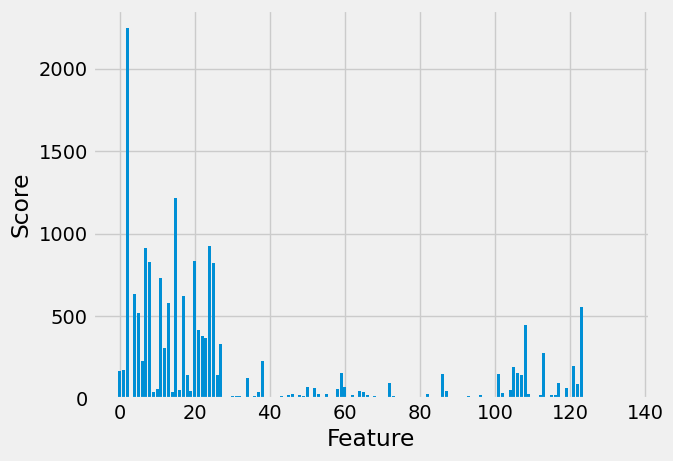

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=80)
fs.fit(X_train_transformed, y_train)

X_train_transformed_fs = fs.transform(X_train_transformed)
X_test_transformed_fs = fs.transform(X_test_transformed)

for i in range(len(fs.scores_)):
    if i == 10:
        print("\n...\n")
        break
    print(f"Feature {i:<3} {fs.scores_[i]:.2f}")


plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel("Feature")
plt.ylabel("Score")
plt.show()

### **Model** **Building**

In [83]:
#import necesary libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [84]:
def evaluation(y, predictions):
    return {
        'MAE': mean_absolute_error(y, predictions),
        'MSE': mean_squared_error(y, predictions),
        'RMSE': np.sqrt(mean_squared_error(y, predictions)),
        'R-squared': r2_score(y, predictions)
    }

### **Linear regression model**

In [85]:
from sklearn.linear_model import LinearRegression

model_name = "LinearRegression"

# Build a Linear Regression model
lin_reg = LinearRegression()

# Fit the model on the transformed and selected training data
lin_reg.fit(X_train_transformed_fs, y_train)

# Predict using the model on the transformed and selected test data
predictions = lin_reg.predict(X_test_transformed_fs)

# Function call to Evaluate results of 'MAE', 'MSE', 'RMSE', 'R-squared'
evaluation_results = evaluation(y_test, predictions)

#RMSE for cross-validation
lr_rmse_cross_val = np.mean(np.sqrt(-cross_val_score(lin_reg, X_train_transformed_fs, y_train, scoring="neg_mean_squared_error")))
""" Calculates the RMSE for cross-validation using the negative mean squared error as the scoring metric.
It then calculates the average RMSE across all cross-validation folds,
which provides an indication of the model's generalization performance on new, unseen data. """


evaluation_results["Model"] = model_name
evaluation_results["RMSE (Cross-Validation)"] = lr_rmse_cross_val

models = pd.DataFrame([evaluation_results])

print("Evaluation Results for", model_name)
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

Evaluation Results for LinearRegression
MAE: 0.08496623216781987
MSE: 0.013283751279005381
RMSE: 0.11525515727725757
R-squared: 0.9093721842223742
Model: LinearRegression
RMSE (Cross-Validation): 15681571618.316814


### **Random Forest Regressor**

In [86]:
from sklearn.ensemble import RandomForestRegressor

model_name = "RandomForest"

# Build a Random Forest model
rand_for = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the transformed and selected training data
rand_for.fit(X_train_transformed_fs, y_train)

# Predict using the model on the transformed and selected test data
predictions = rand_for.predict(X_test_transformed_fs)

# Function call to Evaluate results of 'MAE', 'MSE', 'RMSE', 'R-squared'
evaluation_results = evaluation(y_test, predictions)

#RMSE for cross-validation
rf_rmse_cross_val = np.mean(np.sqrt(-cross_val_score(rand_for, X_train_transformed_fs, y_train, scoring="neg_mean_squared_error")))

evaluation_results["Model"] = model_name
evaluation_results["RMSE (Cross-Validation)"] = rf_rmse_cross_val

models = pd.DataFrame([evaluation_results])

print('-'*30)
print("Evaluation Results for", model_name)
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

------------------------------
Evaluation Results for RandomForest
MAE: 0.0898860439432016
MSE: 0.016660196630142187
RMSE: 0.12907438409747377
R-squared: 0.8863365325574961
Model: RandomForest
RMSE (Cross-Validation): 0.14453516274360123


### **Gradient Boosting Regressor**

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

model_name = "GradientBoostingRegressor"

# Build a Gradient Boost model
g_boost = GradientBoostingRegressor(random_state=0)

# Fit the model on the transformed and selected training data
g_boost.fit(X_train_transformed_fs, y_train)

# Predict using the model on the transformed and selected test data
predictions = g_boost.predict(X_test_transformed_fs)

# Function call to Evaluate results of 'MAE', 'MSE', 'RMSE', 'R-squared'
evaluation_results = evaluation(y_test, predictions)

#RMSE for cross-validation
gb_rmse_cross_val = np.mean(np.sqrt(-cross_val_score(g_boost, X_train_transformed_fs, y_train, scoring="neg_mean_squared_error")))

evaluation_results["Model"] = model_name
evaluation_results["RMSE (Cross-Validation)"] = gb_rmse_cross_val

models = pd.DataFrame([evaluation_results])

print("Evaluation Results for", model_name)
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")


Evaluation Results for GradientBoostingRegressor
MAE: 0.080308423456977
MSE: 0.012458479204511924
RMSE: 0.11161755777883658
R-squared: 0.9150025670835634
Model: GradientBoostingRegressor
RMSE (Cross-Validation): 0.13312596693007275


**Comparison of models**

In [91]:
model_results = [
    {"model": "LinearRegression", "RMSE (Cross-Validation)": lr_rmse_cross_val},
    {"model": "RandomForestRegressor", "RMSE (Cross-Validation)": rf_rmse_cross_val},
    {"model": "XGBRegressor", "RMSE (Cross-Validation)": gb_rmse_cross_val}]

In [92]:
#sort models according to there results
sorted_results = sorted(model_results, key=lambda x: x["RMSE (Cross-Validation)"])

# Print the sorted results
for result in sorted_results:
    print(result)

{'model': 'XGBRegressor', 'RMSE (Cross-Validation)': 0.13312596693007275}
{'model': 'RandomForestRegressor', 'RMSE (Cross-Validation)': 0.14453516274360123}
{'model': 'LinearRegression', 'RMSE (Cross-Validation)': 15681571618.316814}


In [93]:
model_names = [model["model"] for model in model_results]
rmse_values = [model["RMSE (Cross-Validation)"] for model in model_results]

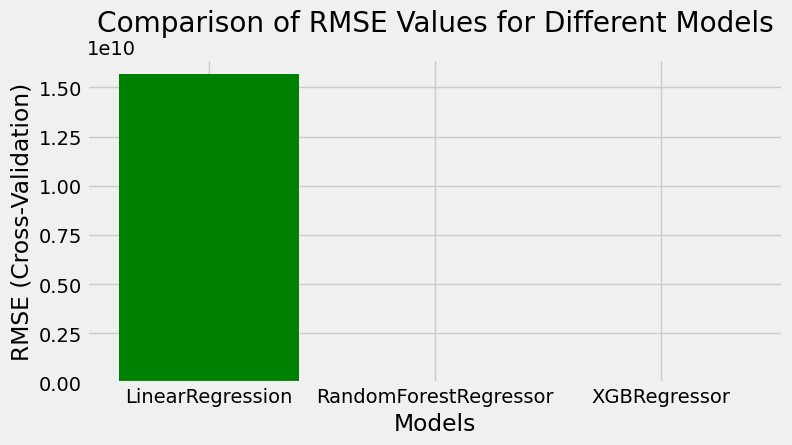

In [95]:
plt.figure(figsize=(8, 4))
plt.bar(model_names, rmse_values, color=['green', 'blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('Comparison of RMSE Values for Different Models')
plt.show()

The results are clear that linear regression model is not giving good performance as its RMSE (Cross-Validation) is way larger than other models and other both models are pretty much close to the results.

### **Predictions on Test Data**
- Now its time to test our best model on the (test data)

In [96]:
# transform the test data to have the same selected features as the training data
#because the sequential nature of the model makes it more sensitive to the number of features used in training and prediction
X_test_selected = fs.transform(test_data)

#transformed and origional results
y_pred = np.exp(g_boost.predict(X_test_selected))
y_pred

array([241617.64939865, 286097.53993208, 274730.20186064, ...,
       254118.00715268, 250383.64771187, 352726.59730063])

In [97]:
submission = pd.DataFrame({
        "Id": test_data.index,
        "SalePrice": y_pred
    })

In [98]:
submission

,Id,SalePrice
0,1461,241617.649399
1,1462,286097.539932
2,1463,274730.201861
3,1464,328441.703325
4,1465,489933.751153
...,...,...
1454,2915,232351.288029
1455,2916,216022.839717
1456,2917,254118.007153
1457,2918,250383.647712
